#### Busqueda tipo waze/google maps

Nuestro objetivo es crear una heuristica creativa y util para  encontrar la mejor ruta entre dos lugares del municipio de Envigado   
Priemero haremos la definición de nuestro grafo 

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

import matplotlib.pyplot as plt
import plotly_express as px

import networkx as nx
import osmnx as ox

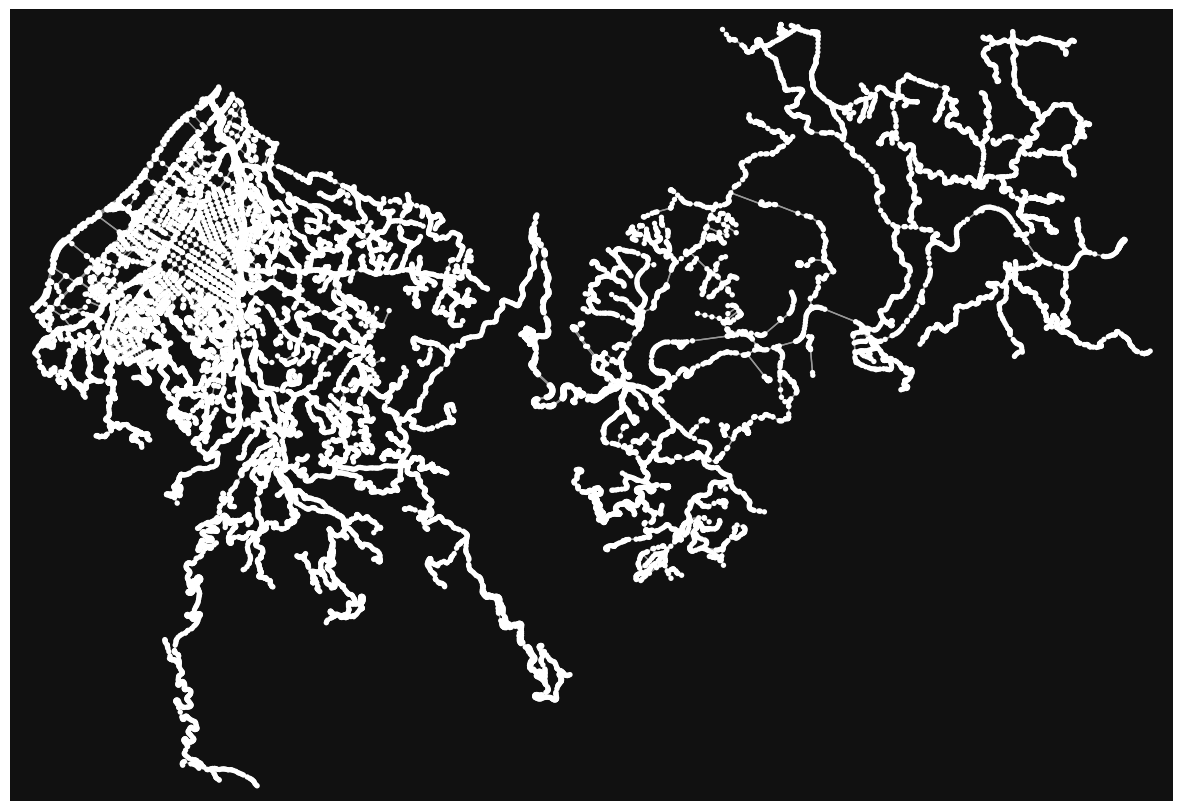

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [2]:
G = ox.graph_from_place('Envigado, Antioquia, Colombia', network_type='drive', simplify=False)
ox.plot_graph(G,figsize=(15,15))

Con esta función graph to *graph_to_gdfs(G)* traemos los nodos y aristas de nuestro grafo como un DF

In [3]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

In [4]:
gdf_edges.head()

osmid    highway lanes maxspeed  \
u         v          key                                         
309313450 414940715  0    1019189334  secondary     2       50   
          440765240  0    1019189334  secondary     2       50   
309313451 414940727  0    1019189334  secondary     2       50   
          414940715  0    1019189334  secondary     2       50   
309313454 4124260034 0    1019190824  secondary     2       60   

                                         name  oneway  reversed     length  \
u         v          key                                                     
309313450 414940715  0    Variante Las Palmas   False     False  24.138083   
          440765240  0    Variante Las Palmas   False      True  91.294214   
309313451 414940727  0    Variante Las Palmas   False     False  26.537531   
          414940715  0    Variante Las Palmas   False      True  27.314193   
309313454 4124260034 0    Variante Las Palmas   False     False  25.381809   

                          ref width junction bridge access  \
u         v          key                                     
309313450 414940715  0    NaN   NaN      NaN    NaN    NaN   
          440765240  0    NaN   NaN      NaN    NaN    NaN   
309313451 414940727  0    NaN   NaN      NaN    NaN    NaN   
          414940715  0    NaN   NaN      NaN    NaN    NaN   
309313454 4124260034 0    NaN   NaN      NaN    NaN    NaN   

                                                                   geometry  
u         v          key                                                     
309313450 414940715  0    LINESTRING (-75.51982 6.15843, -75.52004 6.15839)  
          440765240  0    LINESTRING (-75.51982 6.15843, -75.51903 6.15866)  
309313451 414940727  0     LINESTRING (-75.52028 6.1584, -75.52051 6.15847)  
          414940715  0     LINESTRING (-75.52028 6.1584, -75.52004 6.15839)  
309313454 4124260034 0     LINESTRING (-75.5215 6.15963, -75.52164 6.15981)

### Manipulación del Df
Debemos tener las variables necesarias para poder hacer nuestra heuristica 

1. Vamos a llenar todas las velocidades para poder crear el travel time 


In [5]:
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 37238 entries, (np.int64(309313450), np.int64(414940715), np.int64(0)) to (np.int64(13050291096), np.int64(1863096087), np.int64(0))
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   osmid        37238 non-null  int64   
 1   highway      37238 non-null  object  
 2   lanes        8580 non-null   object  
 3   maxspeed     4364 non-null   object  
 4   name         15637 non-null  object  
 5   oneway       37238 non-null  bool    
 6   reversed     37238 non-null  bool    
 7   length       37238 non-null  float64 
 8   speed_kph    37238 non-null  float64 
 9   travel_time  37238 non-null  float64 
 10  ref          828 non-null    object  
 11  width        570 non-null    object  
 12  junction     314 non-null    object  
 13  bridge       208 non-null    object  
 14  access       58 non-null     object  
 15  geometry     37238 non-null  geometry
dt

2. Vamos a añadir la elevación de las aristas

2. Importamos el tipo de superficie y la añadimos a nuestro DF 

In [6]:
gdf_surface = ox.features.features_from_place("Envigado, Antioquia, Colombia", tags={'surface': True})

def add_surface_data_safe(gdf_edges, gdf_surface):
    edges_with_surface = gdf_edges.copy()
    
    # Inicializar columna surface
    edges_with_surface['surface'] = 'asphalt'  # valor por defecto
    
    # Para cada feature de superficie, encontrar aristas que intersectan
    for idx, surface_feature in gdf_surface.iterrows():
        if pd.isna(surface_feature['surface']):
            continue
            
        # Encontrar aristas que intersectan con esta superficie
        mask = edges_with_surface.geometry.intersects(surface_feature.geometry)
        
        # Asignar el tipo de superficie
        edges_with_surface.loc[mask, 'surface'] = surface_feature['surface']
    
    return edges_with_surface


In [33]:
gdf_edgesMod = add_surface_data_safe(gdf_edges, gdf_surface)

print("Índices originales:", gdf_edges.index.names)
print("Índices modificados:", gdf_edgesMod.index.names)
# Conteo por tipo de superficie
conteo = gdf_edgesMod['surface'].value_counts(dropna=False)
print(conteo)

Gsurface = ox.graph_from_gdfs(gdf_nodes, gdf_edgesMod)


Índices originales: ['u', 'v', 'key']
Índices modificados: ['u', 'v', 'key']
surface
asphalt            31926
unpaved             2758
paved               2075
gravel               231
concrete             151
concrete:lanes        54
paving_stones         32
cobblestone            8
concrete:plates        3
Name: count, dtype: int64


In [21]:
surface_weights = {
    'asphalt': 1.0,             
    'concrete': 1.1,
    'concrete:lanes': 1.1,
    'concrete:plates': 1.2,
    'paved': 1.2,
    'paving_stones': 1.4,
    'fine_gravel': 1.6,
    'gravel': 2.0,
    'cobblestone': 2.2,
    'ground': 2.5,
    'dirt': 3.0,
    'unpaved': 2.8,
    'unknown': 4 
}

def surface_weight(u, v, data):
    surface = data.get('surface', 'unknown')
    length = data.get('length', 1)
    factor = surface_weights.get(surface, 4.0)

    peso = length * factor
    # print(f"De {u} a {v}: superficie={surface}, long={length}, factor={factor}, peso={peso}")
    return peso



In [57]:
import geopy
from geopy.geocoders import Nominatim

locator = Nominatim(user_agent='myGeocoder')

location_start = locator.geocode('Sede Posgrados Eia, Envigado, Colombia')
location_end=locator.geocode('Universidad EIA, Envigado, Colombia')

In [27]:
# Comparar conectividad
print("Grafo original conectado:", nx.is_strongly_connected(G))
print("Grafo con superficie conectado:", nx.is_strongly_connected(Gsurface))

print("Nodos original:", len(G.nodes))
print("Nodos con superficie:", len(Gsurface.nodes))
print("Aristas original:", len(G.edges))
print("Aristas con superficie:", len(Gsurface.edges))

Grafo original conectado: False
Grafo con superficie conectado: False
Nodos original: 20849
Nodos con superficie: 20849
Aristas original: 37238
Aristas con superficie: 37238


In [60]:
start= (location_start.latitude, location_start.longitude)
end= (location_end.latitude, location_end.longitude)

start_node = ox.distance.nearest_nodes(Gsurface, start[1],start[0])
end_node = ox.distance.nearest_nodes(Gsurface, end[1],end[0])

In [ ]:

route1 = nx.shortest_path(G, start_node, end_node, weight=surface_weight)

# Calcular costo total correctamente
costo_total = 0
for u, v, k, data in Gsurface.subgraph(route1).edges(keys=True, data=True):
    costo_total += surface_weight(u, v, data)

print("Costo total ajustado por superficie:", costo_total)

print("Costo total ajustado por superficie:", costo_total)

ox.plot_graph_route(Gsurface, route1, route_linewidth=6, node_size=0, bgcolor='k',figsize=(20, 20))

In [32]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors
# import osmnx as ox

# # Extraer los tipos únicos de superficie para asignar colores
# surfaces = list(gdf_edgesMod['surface'].fillna('unknown').unique())
# surfaces.sort()

# # Crear un mapa de colores personalizado
# color_map = plt.get_cmap("tab20", len(surfaces))
# surface_color_dict = {surf: color_map(i) for i, surf in enumerate(surfaces)}

# # Asignar color a cada arista según su superficie
# edge_colors = gdf_edgesMod['surface'].fillna('unknown').map(surface_color_dict)

# # Dibujar el grafo
# fig, ax = ox.plot_graph(Gsurface,
#                         edge_color=edge_colors.tolist(),
#                         edge_linewidth=3,
#                         node_size=0,
#                         bgcolor='white',
#                         figsize=(30, 30))

# # Mostrar leyenda aparte (opcional)
# legend_patches = [plt.Line2D([0], [0], color=surface_color_dict[surf], lw=3, label=surf) for surf in surfaces]
# plt.figure(figsize=(10, 5))
# plt.legend(handles=legend_patches, loc='center', ncol=4, frameon=False)
# plt.axis('off')
# plt.show()


In [31]:
gdf_hospitals = ox.features_from_place("Envigado", tags={'amenity': 'hospital'})
gdf_schools = ox.features_from_place("Envigado", tags={'amenity': 'school'})
gdf_parks = ox.features_from_place("Envigado", tags={'leisure': 'park'})

# 3. Añadir información al grafo existente (SIN reconstruir)
def add_proximity_features(G, gdf_features, feature_name, buffer_distance=0.001):
    for u, v, key, data in G.edges(keys=True, data=True):
        edge_geom = data['geometry']
        buffer_zone = edge_geom.buffer(buffer_distance)
        
        # Contar features cercanos
        nearby_features = gdf_features[gdf_features.geometry.intersects(buffer_zone)]
        count = len(nearby_features)
        
        # Añadir directamente al grafo
        G[u][v][key][feature_name] = count

# 4. Aplicar a tu grafo
add_proximity_features(Gsurface, gdf_hospitals, 'nearby_hospitals')
add_proximity_features(Gsurface, gdf_schools, 'nearby_schools')
add_proximity_features(Gsurface, gdf_parks, 'crosses_park')

In [49]:
print("Hospitales encontrados:", len(gdf_hospitals))
print("Escuelas encontradas:", len(gdf_schools))
print("Parques encontrados:", len(gdf_parks))

# Ver si tienen geometría válida
if len(gdf_hospitals) > 0:
    print("Hospitales tienen geometría:", not gdf_hospitals.geometry.empty)
if len(gdf_schools) > 0:
    print("Escuelas tienen geometría:", not gdf_schools.geometry.empty)

Hospitales encontrados: 4
Escuelas encontradas: 94
Parques encontrados: 25
Hospitales tienen geometría: True
Escuelas tienen geometría: True


In [46]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(Gsurface)
gdf_edges.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 37238 entries, (np.int64(309313450), np.int64(414940715), np.int64(0)) to (np.int64(13042303314), np.int64(13042303315), np.int64(0))
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   osmid        37238 non-null  int64   
 1   highway      37238 non-null  object  
 2   lanes        8580 non-null   object  
 3   maxspeed     4364 non-null   object  
 4   name         15637 non-null  object  
 5   oneway       37238 non-null  bool    
 6   reversed     37238 non-null  bool    
 7   length       37238 non-null  float64 
 8   speed_kph    37238 non-null  float64 
 9   travel_time  37238 non-null  float64 
 10  geometry     37238 non-null  geometry
 11  surface      37238 non-null  object  
 12  ref          828 non-null    object  
 13  width        570 non-null    object  
 14  bridge       208 non-null    object  
 15  junction     314 non-null    object  
 

In [ ]:
# for u, v, key, data in Gsurface.edges(keys=True, data=True):
#     if 'nearby_hospitals' in data:
#         del Gsurface[u][v][key]['nearby_hospitals']

Nueva función de peso 

In [34]:
def Weight2(u, v, data):
    surface = data.get('surface', 'unknown')
    length = data.get('length', 1)
    hospitals = data.get('nearby_hospitals', 0)
    
    surface_factor = surface_weights.get(surface, 4.0)
    hospital_bonus = 0.5 if hospitals > 0 else 1.0  # 50% descuento si hay hospital cerca

    peso = length * surface_factor * hospital_bonus
    return peso

In [52]:
def force_hospital_weight(u, v, data):
    surface = data.get('surface', 'unknown')
    length = data.get('length', 1)
    hospitals = data.get('nearby_hospitals', 0)
    
    surface_factor = surface_weights.get(surface, 4.0)
    
    # Penalización ENORME si no hay hospital cercano
    hospital_penalty = 1000 if hospitals == 0 else 1.0
    
    peso = length * surface_factor * hospital_penalty
    return peso

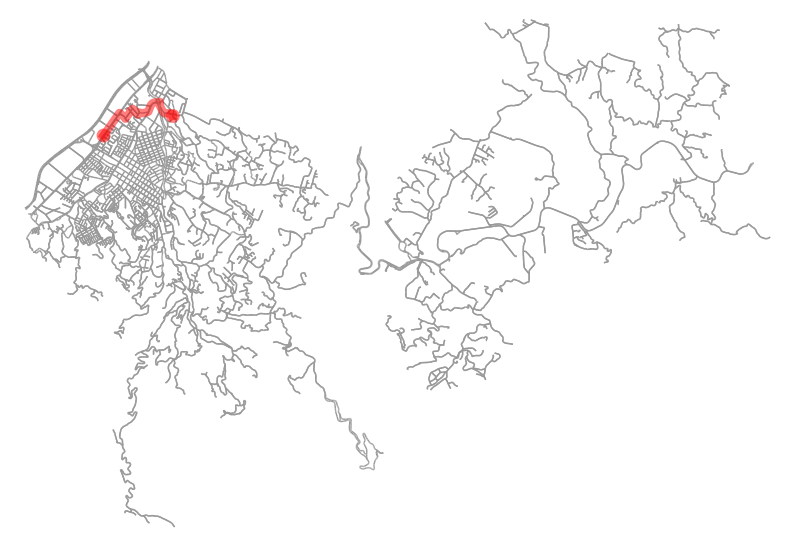

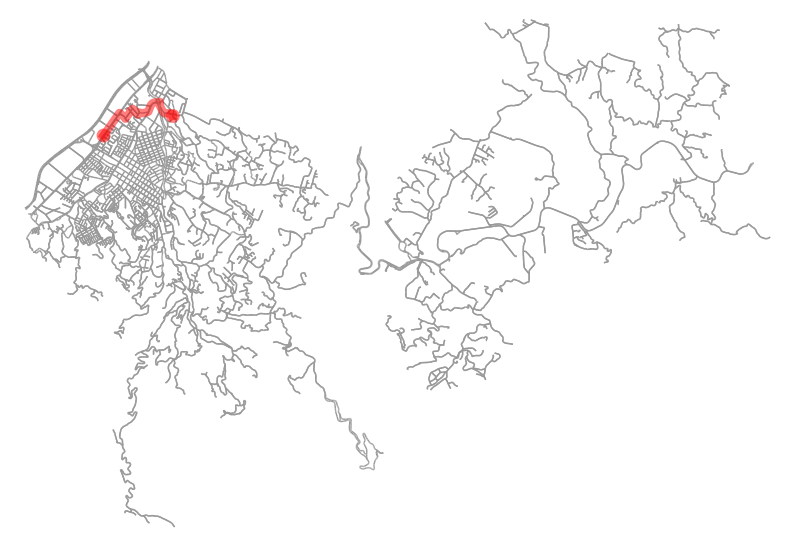

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [53]:
route2 = nx.shortest_path(G, start_node, end_node, weight=surface_weight)
route3 = nx.shortest_path(G, start_node, end_node, weight=force_hospital_weight)


ox.plot_graph_route(Gsurface, route2, route_linewidth=6, node_size=0, bgcolor='w',figsize=(10, 10))
ox.plot_graph_route(Gsurface, route3, route_linewidth=6, node_size=0, bgcolor='w',figsize=(10, 10))

In [54]:
def count_hospitals_in_route(G, route):
    """Contar total de hospitales en toda la ruta"""
    total_hospitals = 0
    
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        edge_data = G[u][v][0]
        total_hospitals += edge_data.get('nearby_hospitals', 0)
    
    return total_hospitals

# Uso
hospital_count = count_hospitals_in_route(Gsurface, route3)
print(f"Total de hospitales en la ruta: {hospital_count}")

Total de hospitales en la ruta: 6


In [55]:
def verify_hospital_route(G, route):
    """Verificar si la ruta pasa por hospitales"""
    hospitals_found = []
    
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        # Obtener datos del edge (puede haber múltiples keys)
        edge_data = G[u][v][0]  # asumiendo key=0, o iterar por todas las keys
        hospitals = edge_data.get('nearby_hospitals', 0)
        
        if hospitals > 0:
            hospitals_found.append({
                'edge': f"{u}-{v}",
                'hospitals': hospitals
            })
    
    return hospitals_found

# Usar después de calcular la ruta
route1 = nx.shortest_path(Gsurface, start_node, end_node, weight=force_hospital_weight)
hospitals_in_route = verify_hospital_route(Gsurface, route1)

print(f"Hospitales encontrados en la ruta: {len(hospitals_in_route)}")
for h in hospitals_in_route:
    print(f"  {h['edge']}: {h['hospitals']} hospitales")

Hospitales encontrados en la ruta: 6
  5496887612-4452257234: 1 hospitales
  4452257234-10313189059: 1 hospitales
  10313189059-4452257232: 1 hospitales
  4452257232-4452257225: 1 hospitales
  4452257225-569133121: 1 hospitales
  569133121-4452257219: 1 hospitales


In [61]:
route_original = nx.shortest_path(Gsurface, start_node, end_node, weight=surface_weight)
route_hospital = nx.shortest_path(Gsurface, start_node, end_node, weight=force_hospital_weight)

# Verificar hospitales en cada ruta
hospitals_original = verify_hospital_route(Gsurface, route_original)
hospitals_hospital = verify_hospital_route(Gsurface, route_hospital)

# Calcular costos
def calculate_route_cost(G, route, weight_function):
    total_cost = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        edge_data = G[u][v][0]
        total_cost += weight_function(u, v, edge_data)
    return total_cost

cost_original = calculate_route_cost(Gsurface, route_original, surface_weight)
cost_hospital = calculate_route_cost(Gsurface, route_hospital, surface_weight)

# Comparación completa
print("=== COMPARACIÓN DE RUTAS ===")
print(f"RUTA ORIGINAL:")
print(f"  Nodos: {len(route_original)}")
print(f"  Segmentos con hospitales: {len(hospitals_original)}")
print(f"  Total hospitales: {sum(h['hospitals'] for h in hospitals_original)}")
print(f"  Costo: {cost_original:.2f}")

print(f"\nRUTA CON HOSPITALES:")
print(f"  Nodos: {len(route_hospital)}")
print(f"  Segmentos con hospitales: {len(hospitals_hospital)}")
print(f"  Total hospitales: {sum(h['hospitals'] for h in hospitals_hospital)}")
print(f"  Costo: {cost_hospital:.2f}")


=== COMPARACIÓN DE RUTAS ===
RUTA ORIGINAL:
  Nodos: 865
  Segmentos con hospitales: 2
  Total hospitales: 2
  Costo: 17263.86

RUTA CON HOSPITALES:
  Nodos: 865
  Segmentos con hospitales: 2
  Total hospitales: 2
  Costo: 17263.86
